# Inverse MPC

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In [13]:



import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer

n, m = 2, 3
x = cp.Variable(n)
A = cp.Parameter((m, n))
b = cp.Parameter(m)
constraints = [x >= 0]
objective = cp.Minimize(0.5 * cp.pnorm(A @ x - b, p=1))
problem = cp.Problem(objective, constraints)
assert problem.is_dpp()

# parameters is the problem parameters
# variables is the problem variables to be optimized
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables=[x])
A_tch = torch.randn(m, n, requires_grad=True)
b_tch = torch.randn(m, requires_grad=True)

# solve the problem
solution, = cvxpylayer(A_tch, b_tch)

# compute the gradient of the sum of the solution with respect to A, b
solution.sum().backward()





In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

from cvxpylayers.torch import CvxpyLayer

import latexify
# latexify.latexify()
%matplotlib inline

torch.set_default_dtype(torch.double)
# torch.set_default_device('cuda:3')


In [4]:
# TODO: make a toy 1D toy example and be able to generate expert demonstration and infer the hidden cost parameter!
# TODO: how to get evaluation loss?


In [2]:
n = 2
m = 1
A_np = np.array([[1., 0.1],[0, 1.]])
B_np = np.array([0,1.]).reshape(-1,1)
A = torch.tensor(A_np)
B = torch.tensor(B_np)
weights = torch.tensor([0.5,1.5])
weights_np = weights.cpu().numpy() # numpy version of the weights
beta = 0.5
T = 5 # look-ahead horizon
def dynamics(xt, ut):
    return A @ xt + B @ ut #+ torch.randn(xt.shape)

def stage_cost(xt, ut):
    return (weights*(xt.pow(2))).sum() + ut.pow(2).sum()

In [12]:
mpc_policy(torch.tensor([1.0,1.0]))

(tensor([-0.5003]),)

In [5]:
def construct_mpc_problem():
    x = cp.Parameter(n) # this is the parameters of the problem
    states = [cp.Variable(n) for _ in range(T)] # this is the decision variables of MPC
    controls = [cp.Variable(m) for _ in range(T)] # this is the decision variables of MPC
    constraints = [states[0] == x, cp.norm(controls[0], 'inf') <= beta] # initial constraints
    objective = cp.sum(cp.multiply(weights_np, cp.square(states[0]))) + cp.sum_squares(controls[0]) # initial objective
    for t in range(1, T):
        objective += cp.sum(cp.multiply(weights_np, cp.square(states[t]))) + cp.sum_squares(controls[t])
        constraints += [states[t] == A_np @ states[t-1] + B_np @ controls[t-1]]
        constraints += [cp.norm(controls[t], 'inf') <= beta] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x]) # why only the first control is optimized?

mpc_policy = construct_mpc_problem()

In [6]:
def simulate(policy, n_iters=1000):
    # x0 = torch.randn(n) # pick a random initial state
    x0 = torch.tensor([1.0, 1.0])
    states = [x0]
    controls = []
    costs = []
    for t in tqdm(range(n_iters)):
        xt = states[-1] # current state
        ut = policy(xt)[0] # current control
        controls.append(ut)
        costs.append(stage_cost(xt, ut).item())
        states.append(dynamics(xt, ut))
    return states[:-1], controls, costs
    
states, controls, costs = simulate(mpc_policy)

for control in controls:
    control.add_(torch.randn(control.shape))
    control.clamp_(-beta, beta)


_, val_mpc_controls, val_mpc_costs = simulate(mpc_policy)
for control in val_mpc_controls:
    control.add_(torch.randn(control.shape))
    control.clamp_(-beta, beta)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
def mse(preds, actual):
    preds = torch.stack(preds, dim=0)
    actual = torch.stack(actual, dim=0)
    return (preds - actual).pow(2).mean(axis=1).mean(axis=0).item()

In [6]:
_, true_copt_controls, _ = simulate(mpc_policy) # forward simulate
true_mse = mse(true_copt_controls, val_mpc_controls)
true_mse

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07708732736943641

In [7]:
# this is the lifted version of the MPC problem
def construct_agent_mpc_problem():
    x = cp.Parameter(n)
    weights = cp.Parameter(n, nonneg=True)
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    constraints = [states[0] == x, cp.norm(controls[0], 'inf') <= beta]
    objective = cp.sum(cp.multiply(weights, cp.square(states[0]))) + cp.sum_squares(controls[0])
    for t in range(1, T):
        objective += cp.sum(cp.multiply(weights, cp.square(states[t]))) + cp.sum_squares(controls[t])
        constraints += [states[t] == A_np @ states[t-1] + B_np @ controls[t-1]]
        constraints += [cp.norm(controls[t], 'inf') <= beta] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x, weights])

In [14]:
adp_policy = construct_agent_mpc_problem()



weights_tch = 0.5*torch.ones(n, requires_grad=True)
state_feedback_policy = lambda x: adp_policy(x, weights_tch)

epochs = 20 # this is for training
val_losses = []
losses = []
with torch.no_grad():
    _, initial_preds, _ = simulate(state_feedback_policy)
    val_losses.append(mse(initial_preds, val_mpc_controls))
    print(val_losses[-1])
opt = torch.optim.Adam([weights_tch], lr=3e-4) # this defines the optimizer

# We finally began the training loop!

for epoch in range(epochs):
    print('Epoch: ', epoch)
    for xt, ut in tqdm(zip(states, controls)):
        opt.zero_grad()
        ut_hat = adp_policy(xt, weights_tch)[0]
        loss = (ut - ut_hat).pow(2).mean()
        loss.backward()
        losses.append(loss.item())
        opt.step()
    with torch.no_grad():
        weights_tch.data = weights_tch.relu()
        _, pred_ctrls, _ = simulate(state_feedback_policy)
        val_losses.append(mse(pred_ctrls, val_mpc_controls))
    print(val_losses[-1])

NameError: name 'construct_agent_mpc_problem' is not defined

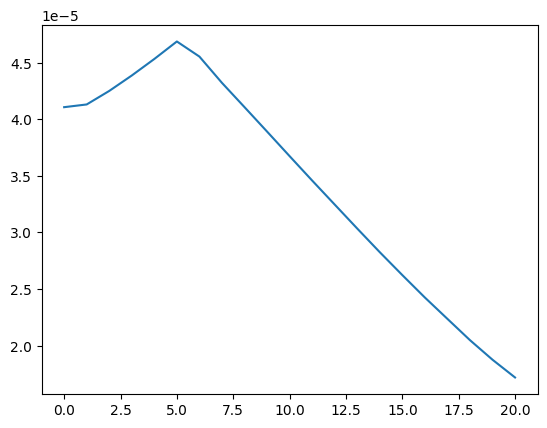

In [ ]:
plt.plot([item - true_mse for item in val_losses])

In [ ]:
state_feedback_policy = lambda x: adp_policy(x, weights_tch)
agent_states, agent_controls, agent_costs = simulate(state_feedback_policy)

In [12]:
weights_np

array([0.5, 1.5])

In [11]:
weights_tch

tensor([0.9522, 1.0470], device='cuda:3', requires_grad=True)

In [ ]:
def plot_weights(w, h):
    fig = plt.figure()
    fig.set_size_inches((w, h))
    plt.plot(weights_tch.detach().numpy(), linestyle='-', color='k', label='learned')
    plt.plot(weights_np, linestyle='--', color='k', label='true')
    plt.xlabel(r'$i$')
    plt.ylabel(r'$\theta_i$')
    plt.legend()
    plt.tight_layout()

In [ ]:
w, h = 10., 3.5
plot_weights(w, h)
plt.show()

### NN

In [ ]:
class FF(torch.nn.Module):
    def __init__(self):
        super(FF, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=n, out_features=n)
        self.fc2 = torch.nn.Linear(in_features=n, out_features=m)
        
    def forward(self, x):
        h1 = self.fc1(x).relu()
        return self.fc2(h1).clamp(-beta, beta)

In [ ]:
torch.random.manual_seed(0)
ff = FF()


epochs = 100
nn_losses = []
val_nn_losses = []
opt = torch.optim.Adam(ff.parameters(), lr=3e-4)
for epoch in range(epochs):
    print('Epoch: ', epoch)
    for xt, ut in tqdm(zip(states, controls)):
        opt.zero_grad()
        ut_hat = ff(xt)
        loss = (ut - ut_hat).pow(2).mean()
        loss.backward()
        nn_losses.append(loss.item())
        opt.step()
    _, val_preds, _ = simulate(lambda x: [ff(x)], seed=val_seed)
    with torch.no_grad():
        val_nn_losses.append(mse(val_preds, val_mpc_controls))
    print(val_nn_losses[-1])

In [ ]:
val_losses[-1]

In [ ]:
val_nn_losses[-1]

In [ ]:
plt.plot(val_nn_losses)

In [ ]:
def plot_losses(w, h):
    fig = plt.figure()
    fig.set_size_inches((w, h))
    plt.axhline(val_nn_losses[-1], color='k', linestyle='-.', label='NN')    
    plt.plot(np.arange(len(val_losses)) + 1, val_losses, color='k', label='COM')
    plt.axhline(true_mse, color='k', linestyle='--', label='true')
    plt.xticks([1, 5, 10, 15, 20])
    plt.xlabel('iteration')
    plt.ylabel('validation loss')
    plt.legend(loc='upper right')
    plt.tight_layout()

In [ ]:
w, h = 10, 3.5
plot_losses(w, h)
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

import latexify
# latexify.latexify()

w = 10
h = 3.5

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(w, h)

ax[1].plot(weights_tch.detach().numpy(), linestyle='-', color='k', label='learned')
ax[1].plot(weights_np, linestyle='--', color='k', label='true')
ax[1].set_xlabel(r'$i$')
ax[1].set_ylabel(r'$\theta_i$')
ax[1].set_xticks([0, 2,4, 6, 8])
ax[1].legend()
    
ax[0].axhline(val_nn_losses[-1], color='k', linestyle='-.', label='NN')
ax[0].plot(np.arange(len(val_losses)) + 1, val_losses, color='k', label='COM')
ax[0].axhline(true_mse, color='k', linestyle='--', label='true')
ax[0].set_xticks([1, 5, 10, 15, 20])
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('validation loss')
ax[0].legend(loc='upper right')

plt.tight_layout()
plt.show()